# Аналитика в Яндекс.Афише

Нас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

### Вступление
У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Цель нашей работы - изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

Для достижения задач необходимо получить выгрузку данных, проанализировать их, найти пропущенные значения, выявить их природу, по возможности обоснованно заполнить, а также удалить дубликаты и привести данные к тому типу, с которым будет нагляднее работать. После предобработки данных необходимо построить отчёты и посчитать метрики, которые в итоге нам помогут сделать вывод и рекомендации маркетологам, куда и сколько им стоит вкладывать денег.

Описание данных:

##### Таблица visits (лог сервера с информацией о посещениях сайта):
- *uid* — уникальный идентификатор пользователя
- *device* — категория устройства пользователя
- *start_ts* — дата и время начала сессии
- *end_ts* — дата и время окончания сессии
- *source_id* — идентификатор рекламного источника, из которого пришел пользователь.

##### Таблица orders (информация о заказах):
- *uid* — уникальный id пользователя, который сделал заказ
- *buy_ts* — дата и время заказа
- *revenue* — выручка Яндекс.Афиши с этого заказа

##### Таблица costs (информация о затратах на маркетинг):
- *source_id* — идентификатор рекламного источника
- *dt* — дата
- *costs* — затраты на этот рекламный источник в этот день

### Шаг 1. Загрузить данные и подготовить их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sb

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.info()
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [4]:
costs = pd.read_csv('/datasets/costs.csv')
costs.info()
costs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Видим, что пропущенных значений нет, столбцы с датой необходимо привести к типу данных datetime, а также стоит в первых двух таблицах переименовать столбцы для удобства.

In [5]:
visits = visits.rename(columns={'Device': "device", 'End Ts': 'end_ts', 'Source Id': 'source_id', 'Start Ts': 'start_ts', 'Uid': 'uid'})
orders = orders.rename(columns={'Buy Ts': "buy_ts", 'Revenue': 'revenue', 'Uid': 'uid'})
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits = visits[visits['end_ts'] < '2018-06-01']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders = orders[orders['buy_ts'] < '2018-06-01']
costs['dt'] = pd.to_datetime(costs['dt'])

In [6]:
visits = visits.drop_duplicates()
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359388 entries, 0 to 359399
Data columns (total 5 columns):
device       359388 non-null object
end_ts       359388 non-null datetime64[ns]
source_id    359388 non-null int64
start_ts     359388 non-null datetime64[ns]
uid          359388 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


In [7]:
orders = orders.drop_duplicates()
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 3 columns):
buy_ts     50414 non-null datetime64[ns]
revenue    50414 non-null float64
uid        50414 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


In [8]:
costs = costs.drop_duplicates()
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 79.4 KB


### Вывод:
Мы привели столбцы с датой и временем к типу данных datetime64, а также переименовали названия столбцов - привели их к нижнему регистру, заменив пробелы знаками подчеркивания. Пропущенных значений нет, дубликатов нет.

Данные подготовлены к дальнейшему анализу.

### Шаг 2. Построить отчёты и посчитать метрики.

Выясним, сколько людей пользуются продуктом в день, неделю, месяц.

In [9]:
visits['start_day'] = visits['start_ts'].dt.date
visits['start_week'] = visits['start_ts'].astype('datetime64[W]')
visits['start_month'] = visits['start_ts'].astype('datetime64[M]')

Среднее количество пользователей продукта в день: 908


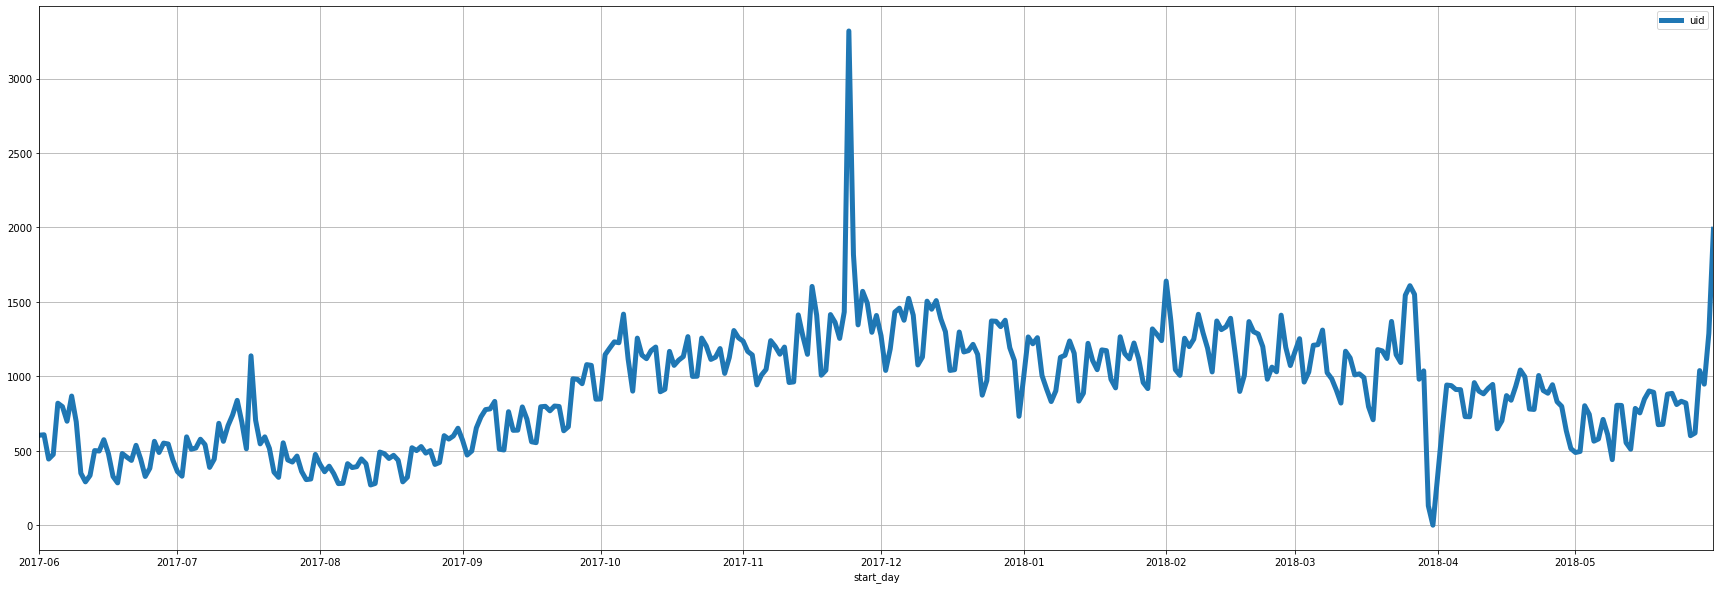

In [10]:
temp = visits.groupby(['start_day']).agg({'uid': 'nunique'})
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
users_per_day = temp['uid'].mean()
print('Среднее количество пользователей продукта в день:', users_per_day.round().astype('int'))

Взглянем, зависит количество пользователей от категории устройства пользователя:

Среднее количество пользователей продукта в день c устройства desktop 659.2252747252747
Среднее количество пользователей продукта в день c устройства touch 252.86501377410468


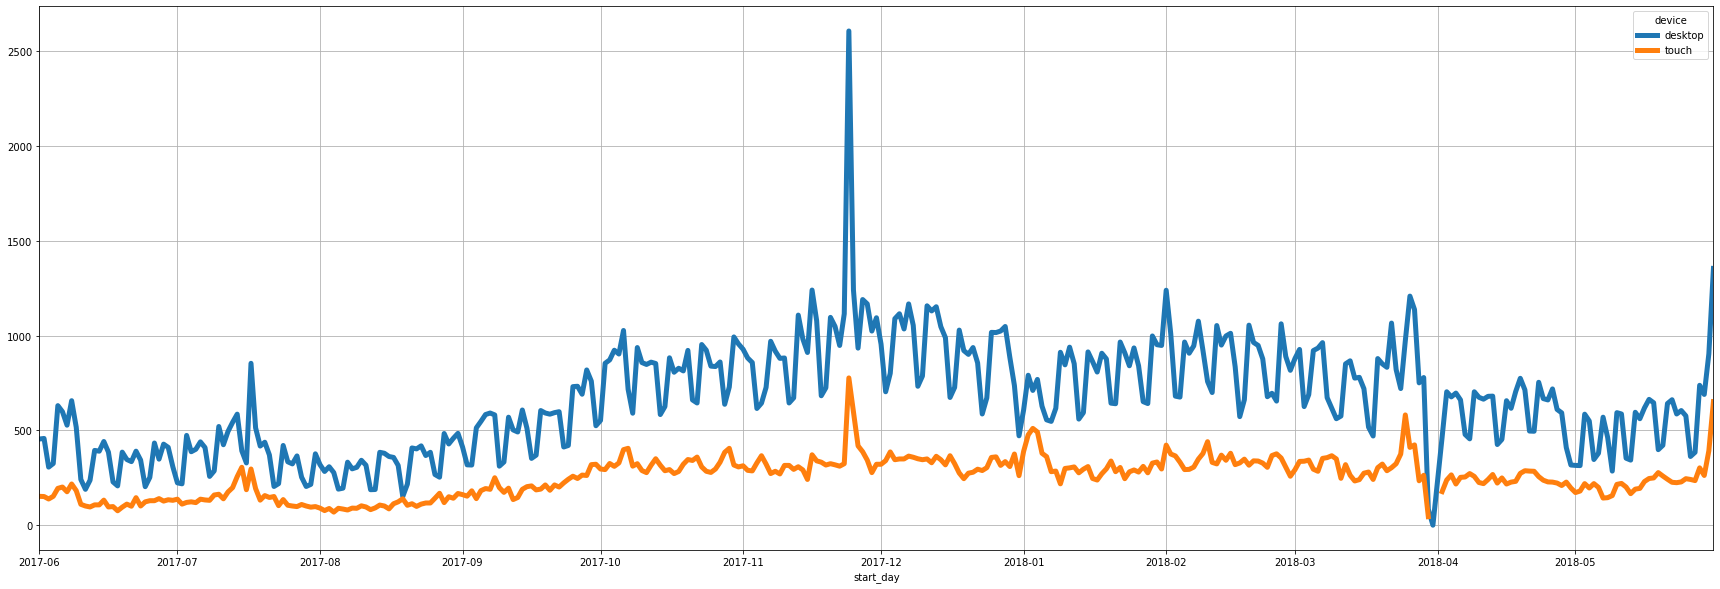

In [11]:
temp = visits.pivot_table(index='start_day', columns='device', values='uid', aggfunc='nunique')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Среднее количество пользователей продукта в день c устройства', i, temp[i].mean())

Взглянем, как меняется количество пользователей ежедневно в зависимости от рекламного источника.

Средняя ежедневная выручка, привлеченная рекламным источником 1 составляет: 80.55
Средняя ежедневная выручка, привлеченная рекламным источником 2 составляет: 120.71
Средняя ежедневная выручка, привлеченная рекламным источником 3 составляет: 232.86
Средняя ежедневная выручка, привлеченная рекламным источником 4 составляет: 275.45
Средняя ежедневная выручка, привлеченная рекламным источником 5 составляет: 175.62
Средняя ежедневная выручка, привлеченная рекламным источником 6 составляет: 1.0
Средняя ежедневная выручка, привлеченная рекламным источником 7 составляет: 1.06
Средняя ежедневная выручка, привлеченная рекламным источником 9 составляет: 36.11
Средняя ежедневная выручка, привлеченная рекламным источником 10 составляет: 26.03


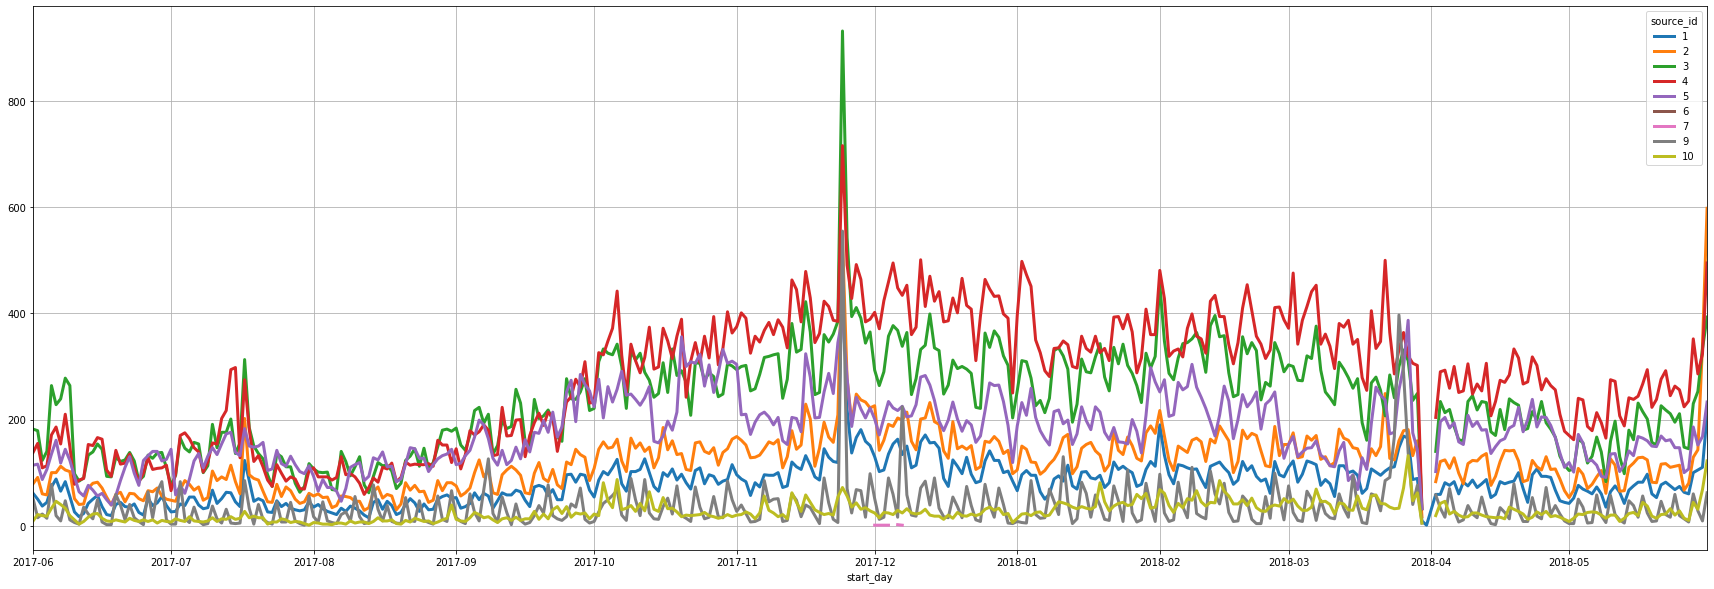

In [12]:
temp = visits.pivot_table(index='start_day', columns='source_id', values='uid', aggfunc='nunique')
temp.plot(figsize=(30, 10), grid=True, linewidth=3)
for i in temp.columns:
    print("Средняя ежедневная выручка, привлеченная рекламным источником", i, 'составляет:', temp[i].mean().round(2))

Графики всех источников похожи, позже будем анализировать эти данные в соотношении с затратами на маркетинг.

Среднее количество пользователей продукта за неделю: 5724


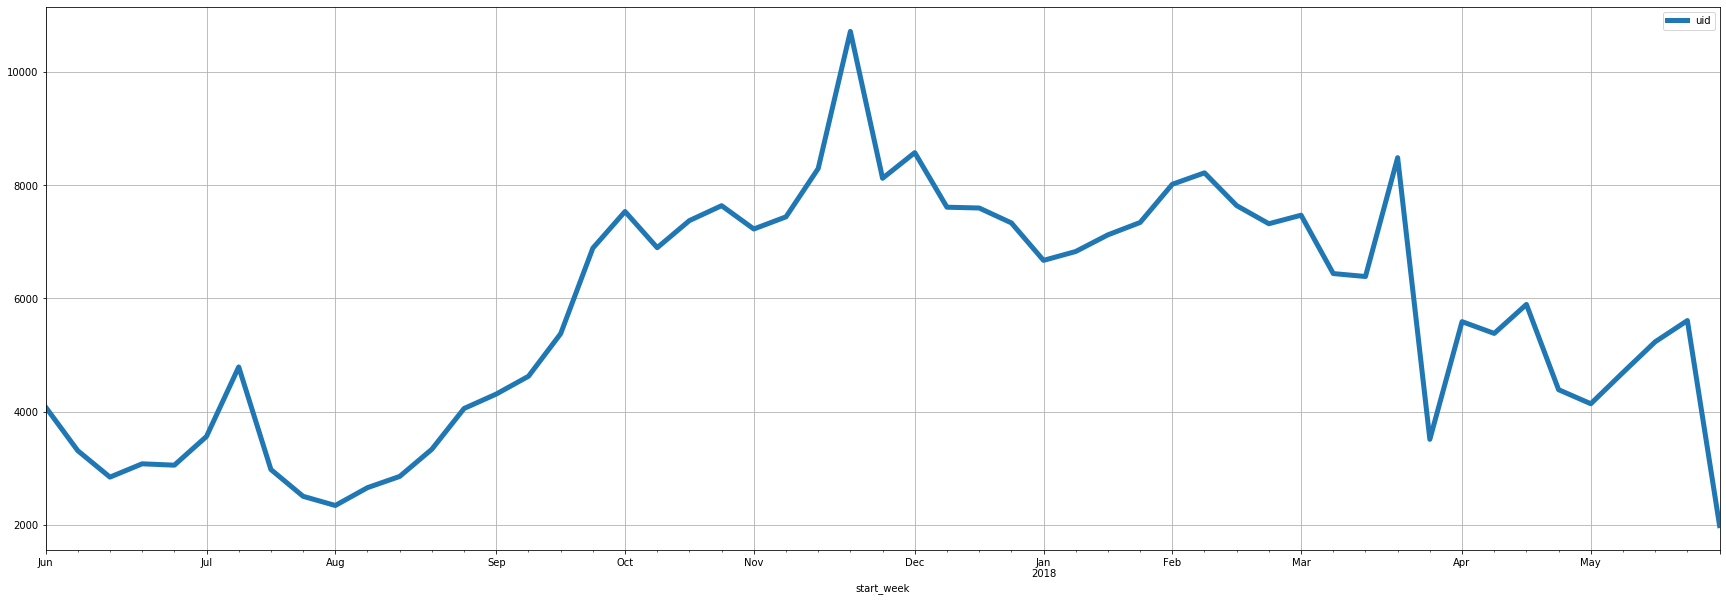

In [13]:
temp = visits.groupby(['start_week']).agg({'uid': 'nunique'})
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
print('Среднее количество пользователей продукта за неделю:', temp['uid'].mean().round().astype('int'))

Также разобьём по устройствам:

Среднее количество пользователей продукта за неделю c устройства desktop 4135.622641509434
Среднее количество пользователей продукта за неделю c устройства touch 1637.2075471698113


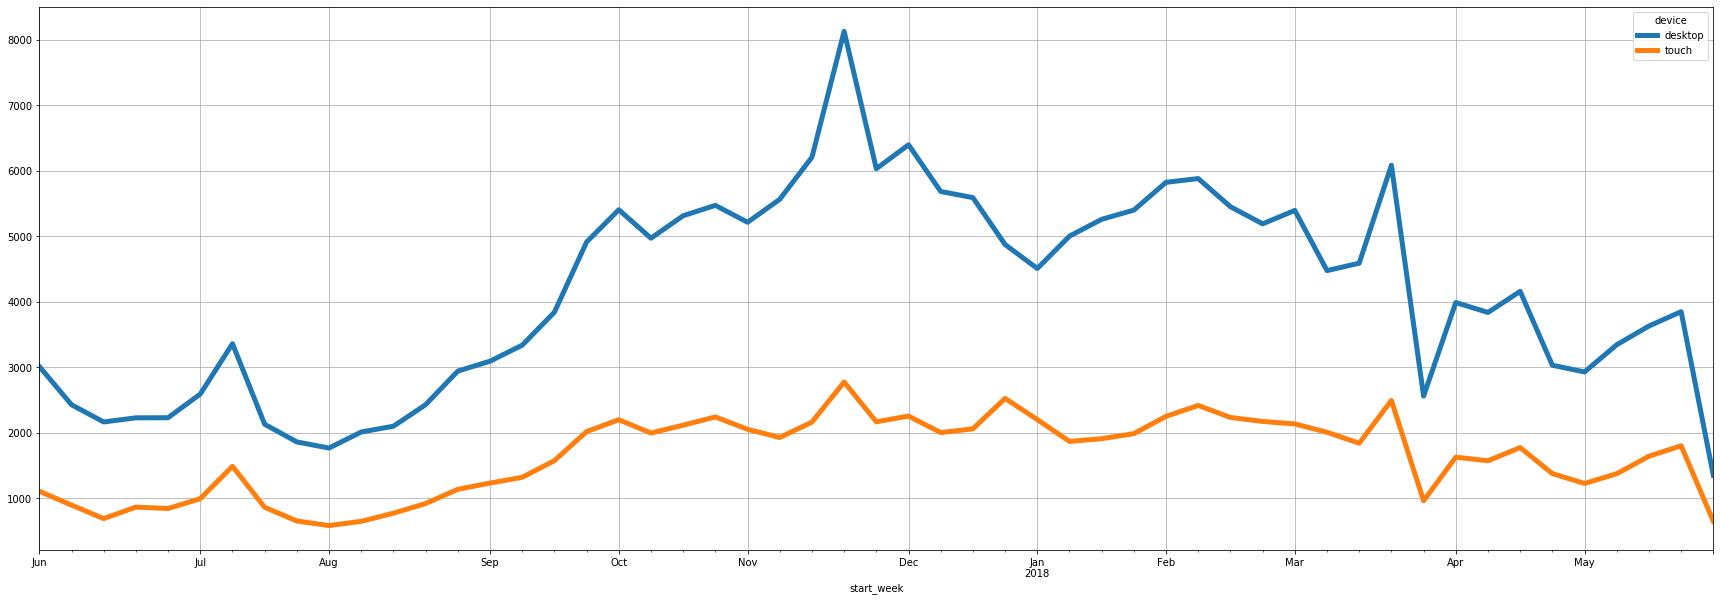

In [14]:
temp = visits.pivot_table(index='start_week', columns='device', values='uid', aggfunc='nunique')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Среднее количество пользователей продукта за неделю c устройства', i, temp[i].mean())

Среднее количество пользователей продукта за месяц: 23228


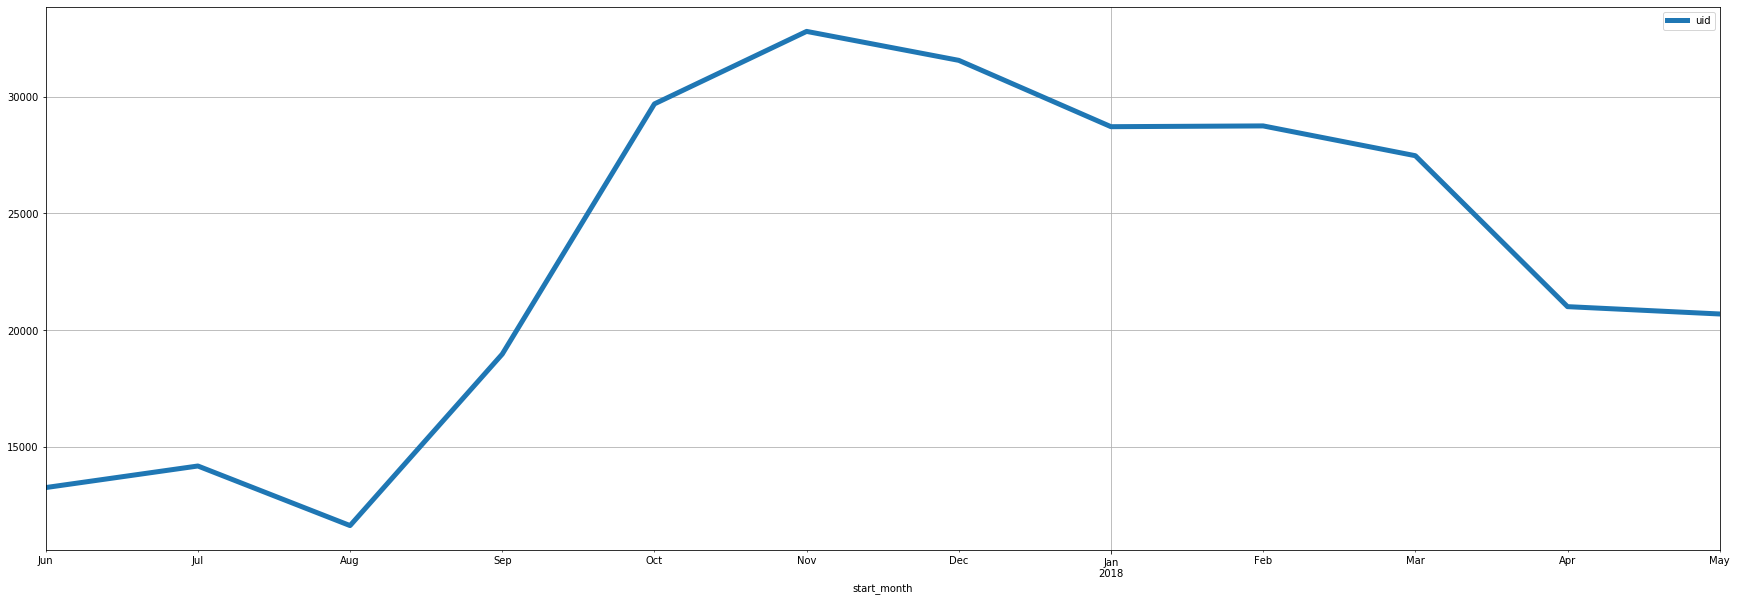

In [15]:
temp = visits.groupby(['start_month']).agg({'uid': 'nunique'})
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
print('Среднее количество пользователей продукта за месяц:', temp['uid'].mean().round().astype('int'))

И ещё раз взглянем на деление по устройствам:

Среднее количество пользователей продукта за месяц c устройства desktop 16724.416666666668
Среднее количество пользователей продукта за месяц c устройства touch 6825.75


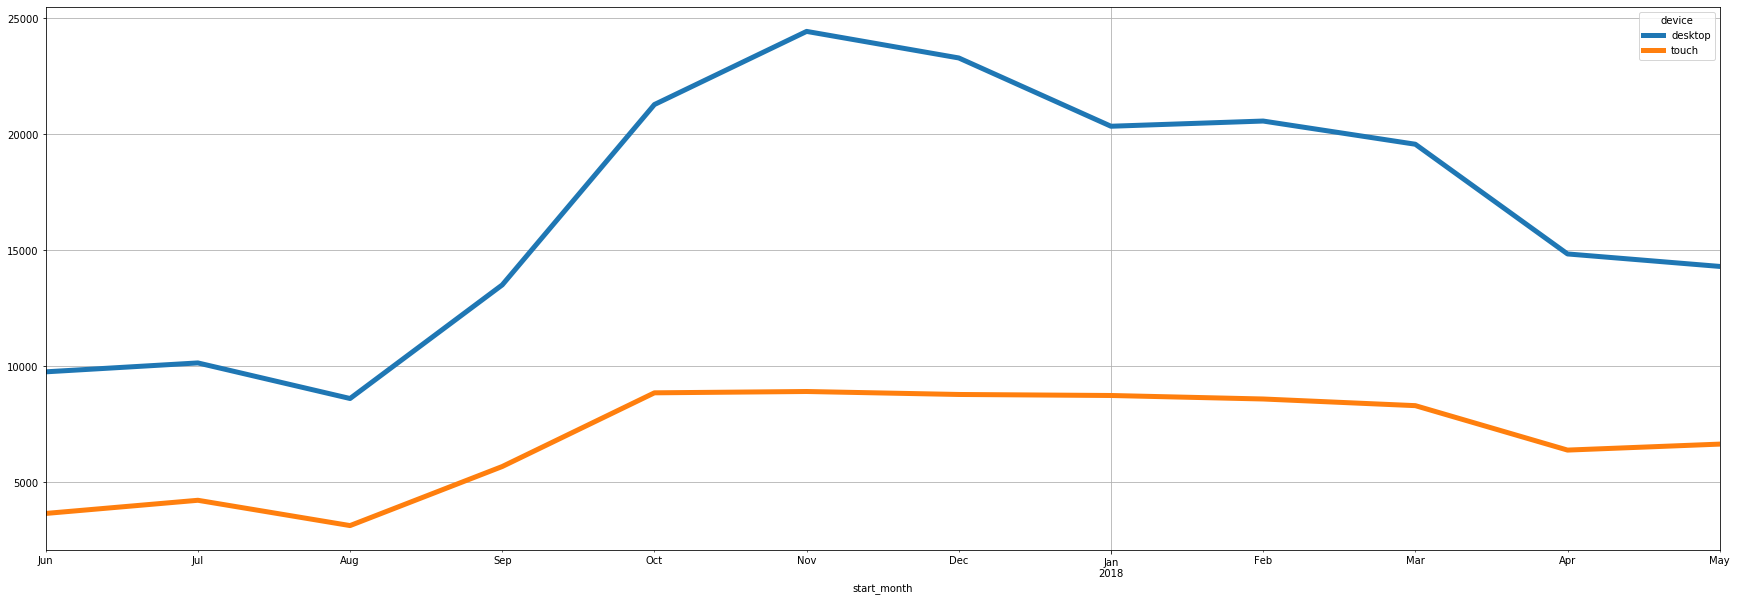

In [16]:
temp = visits.pivot_table(index='start_month', columns='device', values='uid', aggfunc='nunique')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Среднее количество пользователей продукта за месяц c устройства', i, temp[i].mean())

Картина для разных типов устройств одинаковая, но c десктопных устройств количество сессий больше примерно в 2,5 раза. И это прослеживается по всему периоду наших данных анализа.

Посмотрим, сколько сессий в день зарегистрировано.

Среднее количество сессий в день: 987
Каждый пользователь в среднем пользуется продуктом 1.0874069591527988 раз в день


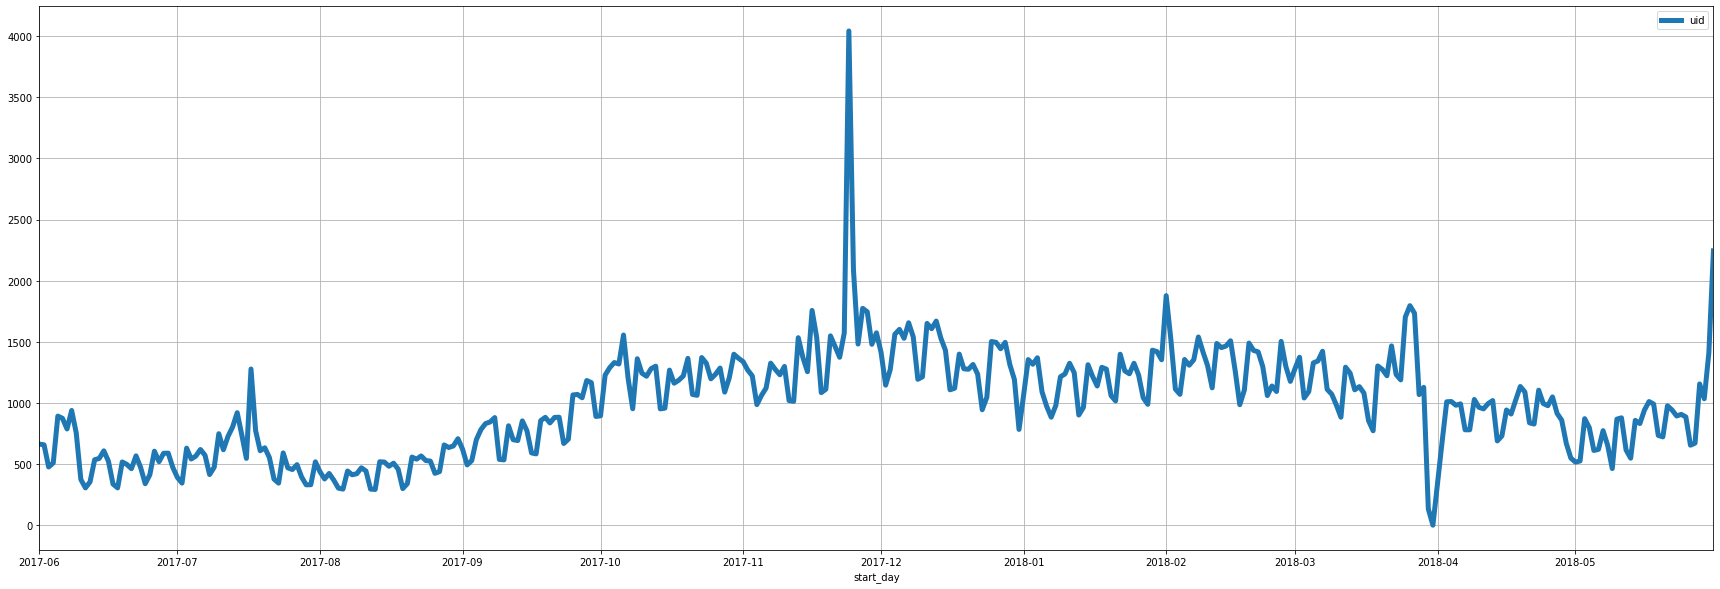

In [17]:
temp = visits.groupby(['start_day']).agg({'uid': 'count'})
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
print('Среднее количество сессий в день:', temp['uid'].mean().round().astype('int'))
print('Каждый пользователь в среднем пользуется продуктом', temp['uid'].mean() / users_per_day, 'раз в день')

Взглянем, сколько в среднем длится одна сессия. Подавляющее большинство значений начала и конца сессии имеют нулевое значение секунд, поэтому нам удобнее будет считать длительность сессии в минутах, округляя секунды, если они встретятся.

In [18]:
visits['session_duration'] = ((visits['end_ts'] - visits['start_ts']) / np.timedelta64(1,'m')).astype('int')
visits.head(10)

,device,end_ts,source_id,start_ts,uid,start_day,start_week,start_month,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-31,2017-09-01,1
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018-01-25,2018-01-01,56
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,2017-11-02,2017-11-01,1
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,2017-07-13,2017-07-01,3
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,2017-11-02,2017-11-01,1


In [19]:
print('В среднем сессия длится:', visits['session_duration'].median(), 'минут.')

В среднем сессия длится: 5.0 минут.


А если длительность сессии равна нулю, то есть у пользователя не было цели пользоваться продуктом, то

In [20]:
print('В среднем сессия длится:', visits[visits['session_duration'] != 0]['session_duration'].median(), 'минут.')

В среднем сессия длится: 6.0 минут.


Разница не столь существенна.

Посмотрим, как часто люди после использования продукта в первый раз, возвращаются к нему. То есть нас интересует Retention Rate пользователей. Для этого нам необходимо разделить пользователей на когорты, согласно каким-либо изменениям в приложении. Если допустить, что приложение, особенно мобильное, обновляется не чаще 1 раза в месяц, то лучше поделить на месяцы.

In [21]:
# найдём для каждого пользователя неделю первой сессии и добавим эти значения в таблицу visits
first_visits = visits.groupby(['uid'])['start_month'].min()
first_visits.name = 'first_visit_month'
visits = visits.join(first_visits, on='uid')

# подсчитаем время жизни когорты для каждой сессии, чтобы потом по нему сгруппировать
visits['cohort_lifetime'] = ((visits['start_month'] - visits['first_visit_month']) / np.timedelta64(1,'M')).round().astype('int')
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [22]:
# Вычислим, сколько было пользователей в нулевую неделю в каждой когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

# Теперь добавим информацию о количестве пользователей каждой когорты в нашу сводную таблицу
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts

,first_visit_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [23]:
# Теперь рассчитаем Retention Rate.
# Разделим количество пользователей для каждой недели активности на изначальное количество пользователей в когорте.
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

# построим сводную таблицу из тех данных, что получили
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
del retention_pivot[0]
retention_pivot.index = retention_pivot.index.astype('str')
retention_pivot

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,
2017-06-01,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


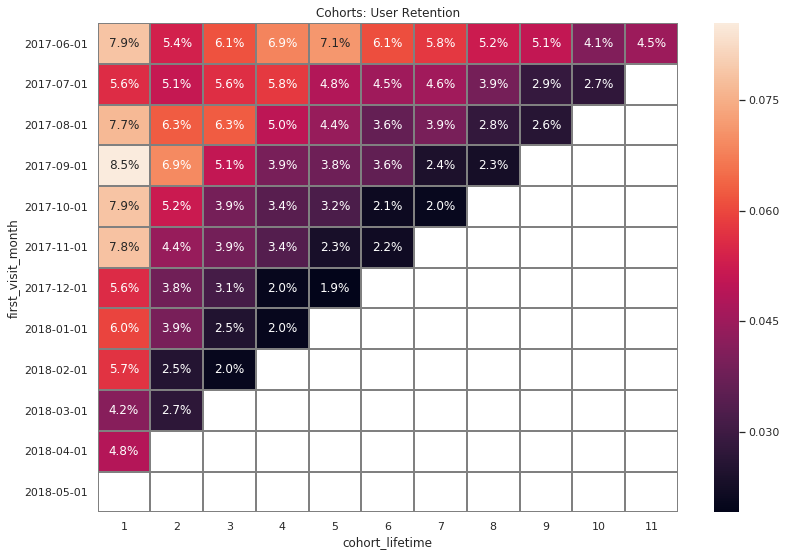

In [24]:
sb.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sb.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Теперь взглянем на таблицу продаж. Посмотрим когда люди начинают покупать?
Успешным привлечнеие пользователя можно назвать, если он оформил покупку в тот же день, когда впервые зашёл, поэтому за временную единицу примем дни.

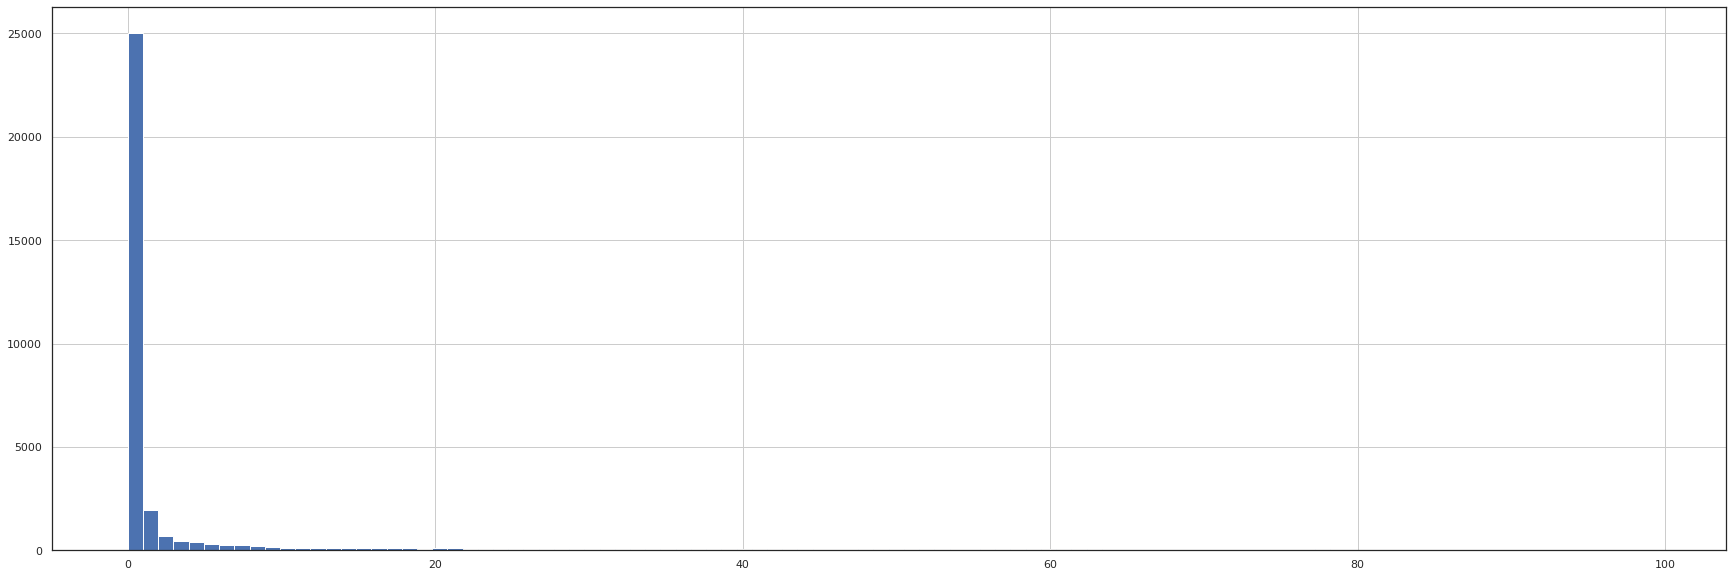

In [25]:
# Сформируем таблицу первых сессий пользователей
first_visits = visits[['uid','start_ts']].pivot_table(index='uid', values='start_ts', aggfunc='min').reset_index()
first_visits = first_visits.rename(columns={'start_ts': 'first_activity_day'})

# сформируем таблицу первых покупок пользователей
first_orders = orders[['uid', 'buy_ts']].pivot_table(index='uid', values='buy_ts', aggfunc='min').reset_index()
first_orders = first_orders.rename(columns={'buy_ts': 'first_buy_day'})

# сведём данные обеих таблиц в одну
first_to_first = first_visits.merge(first_orders, on='uid')
first_to_first['time_to_buy'] = ((first_to_first['first_buy_day'].dt.date - first_to_first['first_activity_day'].dt.date) / np.timedelta64(1,'D')).astype('int')
first_to_first[first_to_first['time_to_buy'] < 100]['time_to_buy'].hist(bins=100, figsize=(30, 10))

Как видим, подавляющее большинство пользователей совершает покупки в тот же день, когда начали работать с продуктом. Низкий коэффициент удержания и данный график говорят о том, что малый процент пользователей продолжает работать с продуктом, и, как следствие, малые повторные продажи.

Узнаем наглядно сколько раз покупают за период (день, месяц)

In [26]:
period_orders = orders.copy()
period_orders['buy_day'] = period_orders['buy_ts'].dt.date
period_orders['buy_month'] = period_orders['buy_ts'].astype('datetime64[M]')
period_orders

,buy_ts,revenue,uid,buy_day,buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
...,...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-31,2018-05-01
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-01


            uid
buy_day        
2017-11-24  814
2018-05-31  610


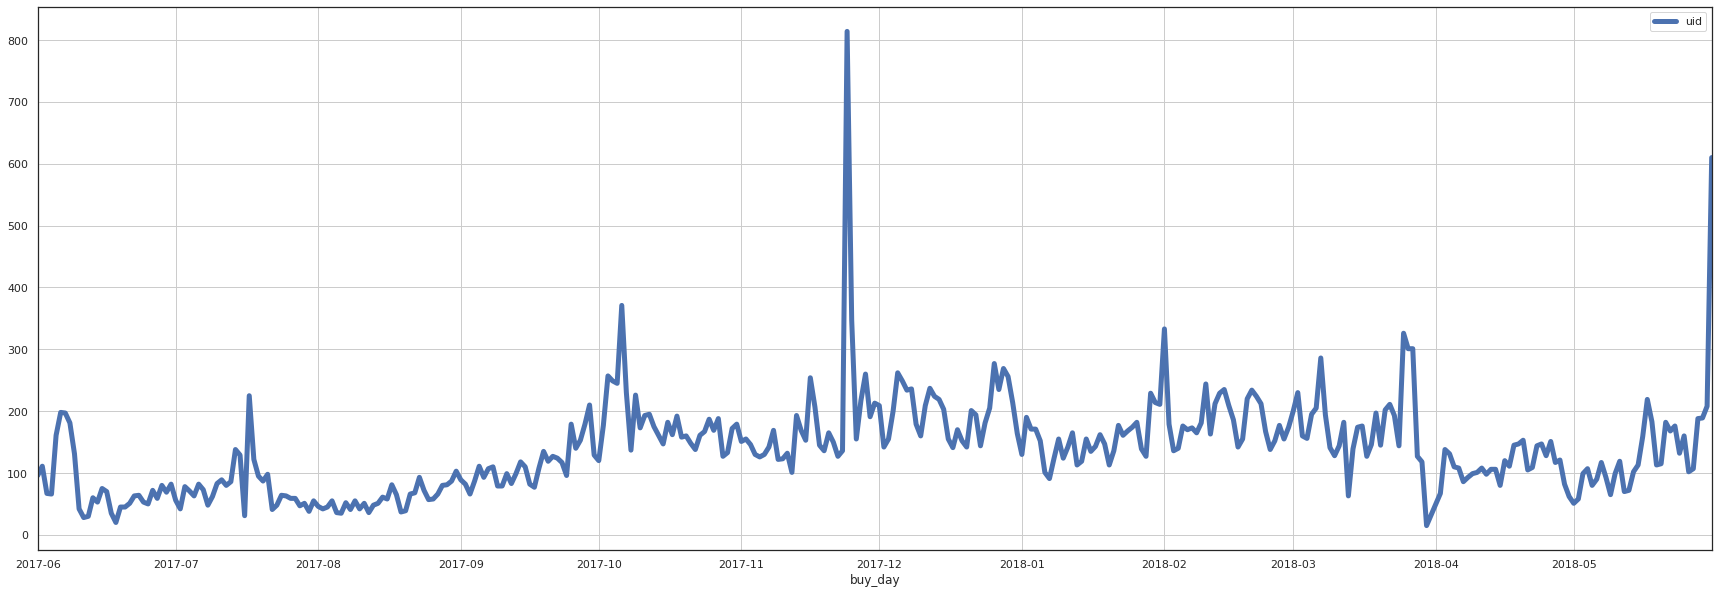

In [27]:
temp = period_orders.pivot_table(index='buy_day', values='uid', aggfunc='count')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
print(temp[temp['uid'] >500])

Теперь видим, что пиковое значение 24.11.2017 выпало на "Чёрную пятницу". Этим и обусловлен аномальный скачок продаж. Также наблюдается скачок в конце мая - похоже, близость летних каникул и фестивалей тоже сказывается на неотложных покупках.

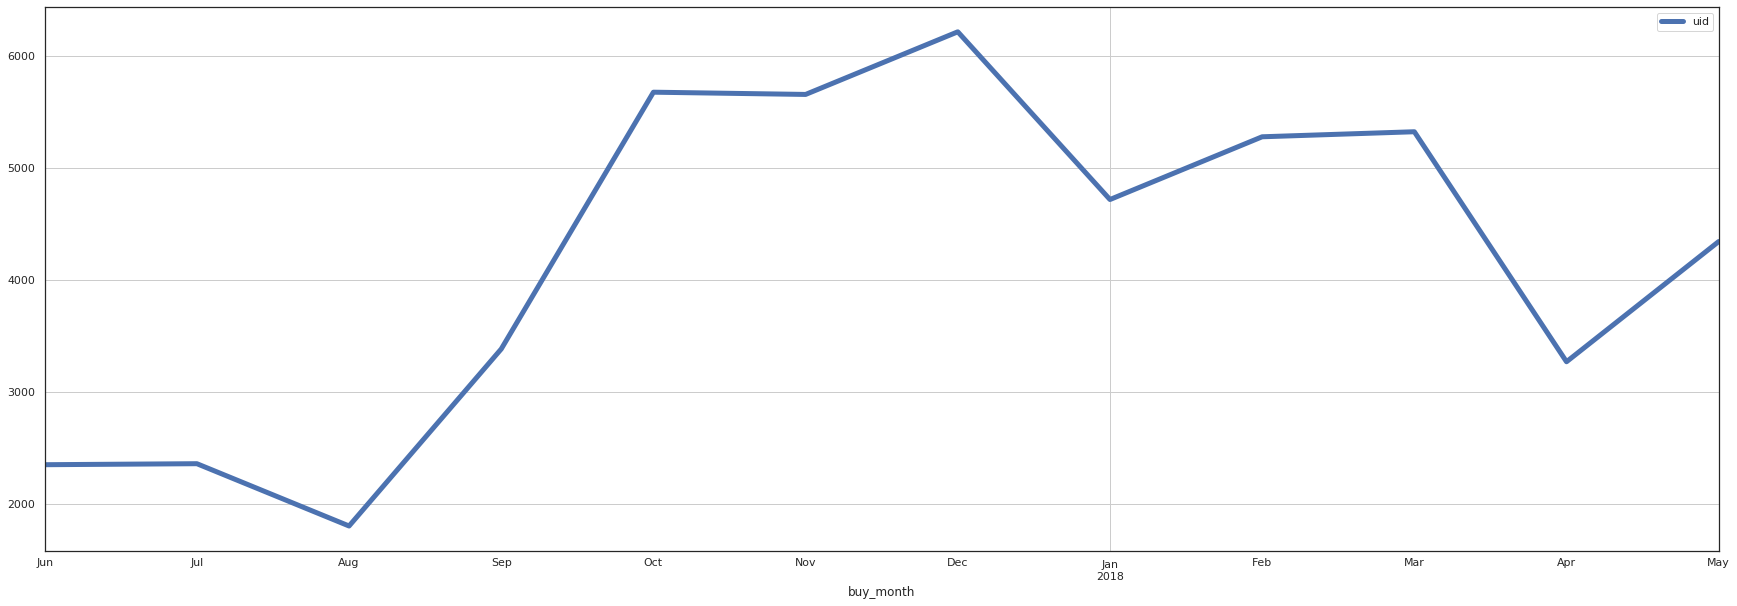

In [28]:
temp = period_orders.pivot_table(index='buy_month', values='uid', aggfunc='count')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)

Похоже, лето - не самая удачная пора для покупки билетов на культурные мероприятия. Людей тянет скорее на Aviasales и Booking.com

Узнаем, какой средний чек за день, неделю и месяц зафиксирован с покупок с разных типов устройств.

In [29]:
# добавим колонку со значениями старта новой недели
period_orders['buy_week'] = period_orders['buy_ts'].astype('datetime64[W]')

# добавим для конкретного uid тип устройства (для каждого uid тип устройства однозначный)
period_orders = period_orders.merge(visits[['uid', 'device']], on='uid')

Средний чек в день c устройства desktop 8.239528323350342
Средний чек в день c устройства touch 8.210438607799002


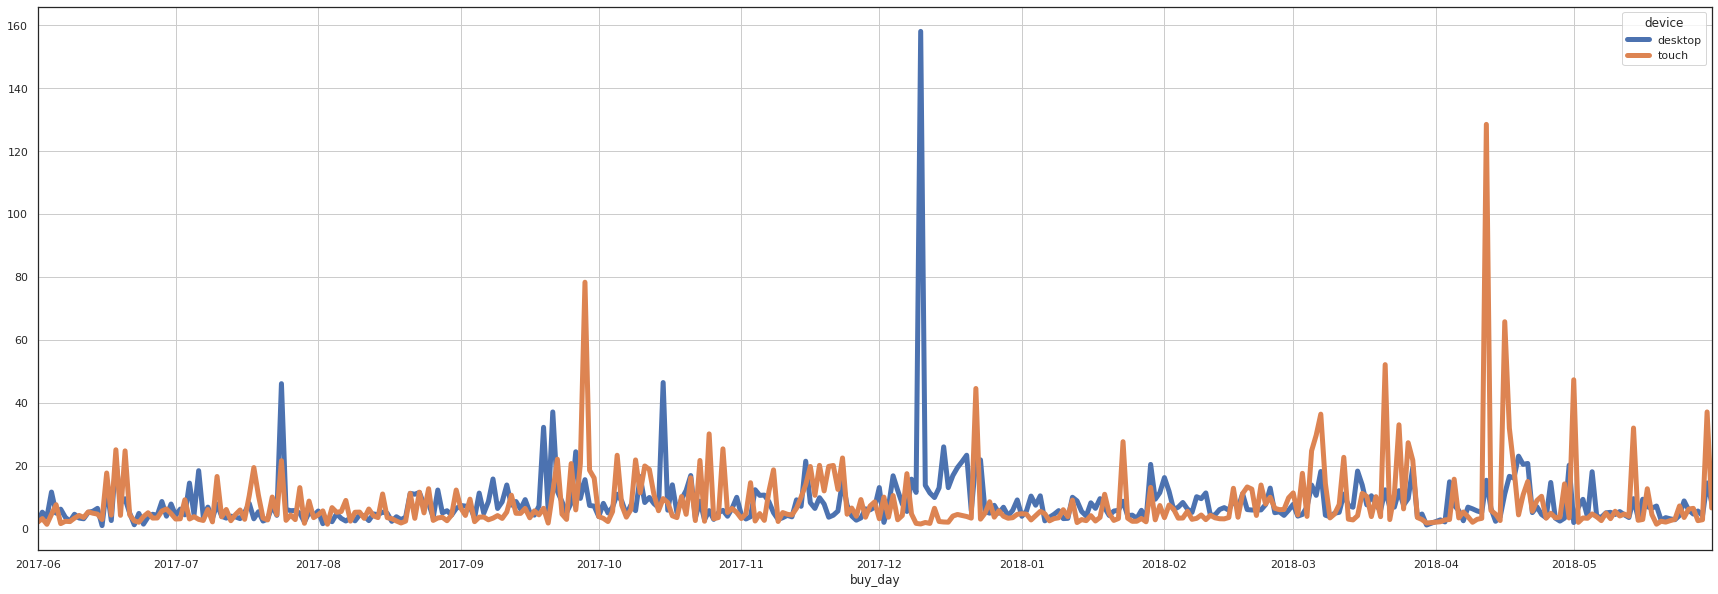

In [30]:
temp = period_orders.pivot_table(index='buy_day', columns='device', values='revenue', aggfunc='mean')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Средний чек в день c устройства', i, temp[i].mean())

Средний чек за неделю c устройства desktop 8.45147811040607
Средний чек за неделю c устройства touch 9.076742021247505


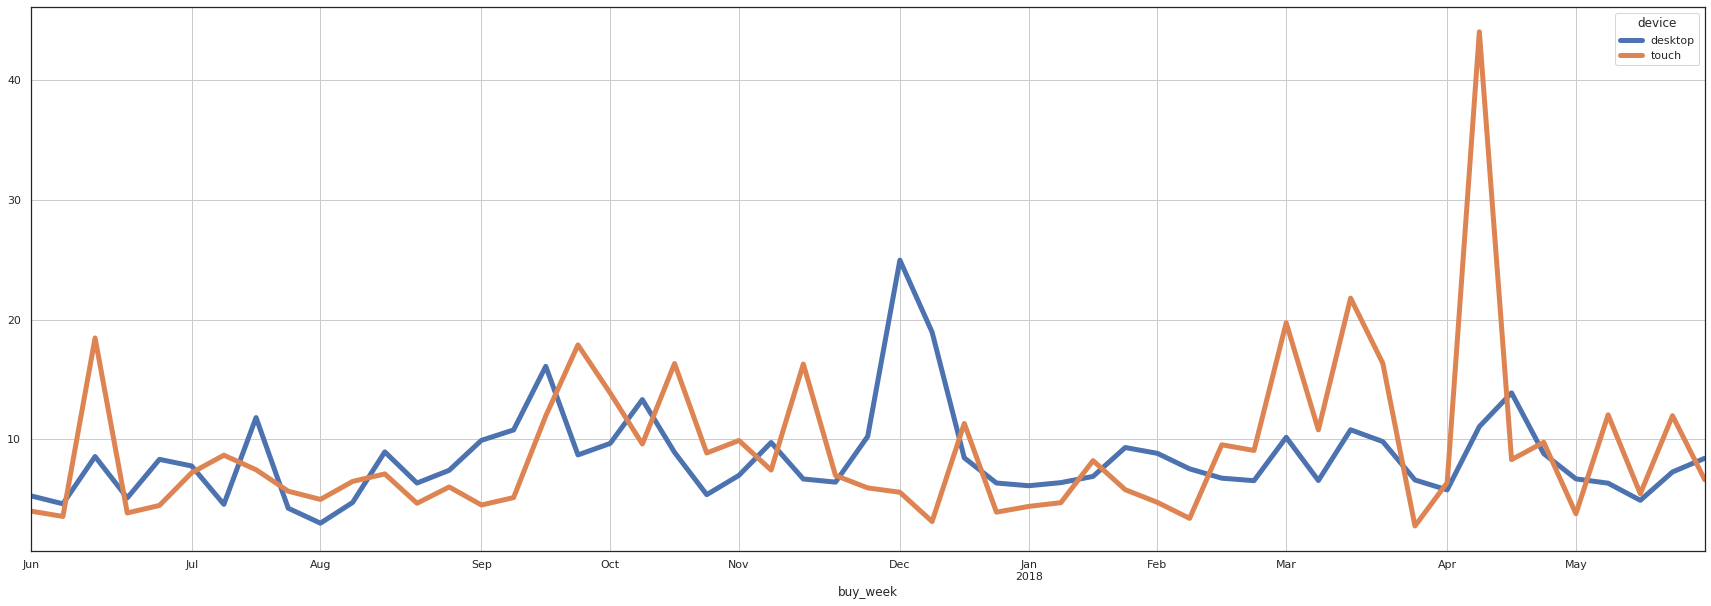

In [31]:
temp = period_orders.pivot_table(index='buy_week', columns='device', values='revenue', aggfunc='mean')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Средний чек за неделю c устройства', i, temp[i].mean())

Средний чек за месяц c устройства desktop 8.48807068113697
Средний чек за месяц c устройства touch 10.01001500434372


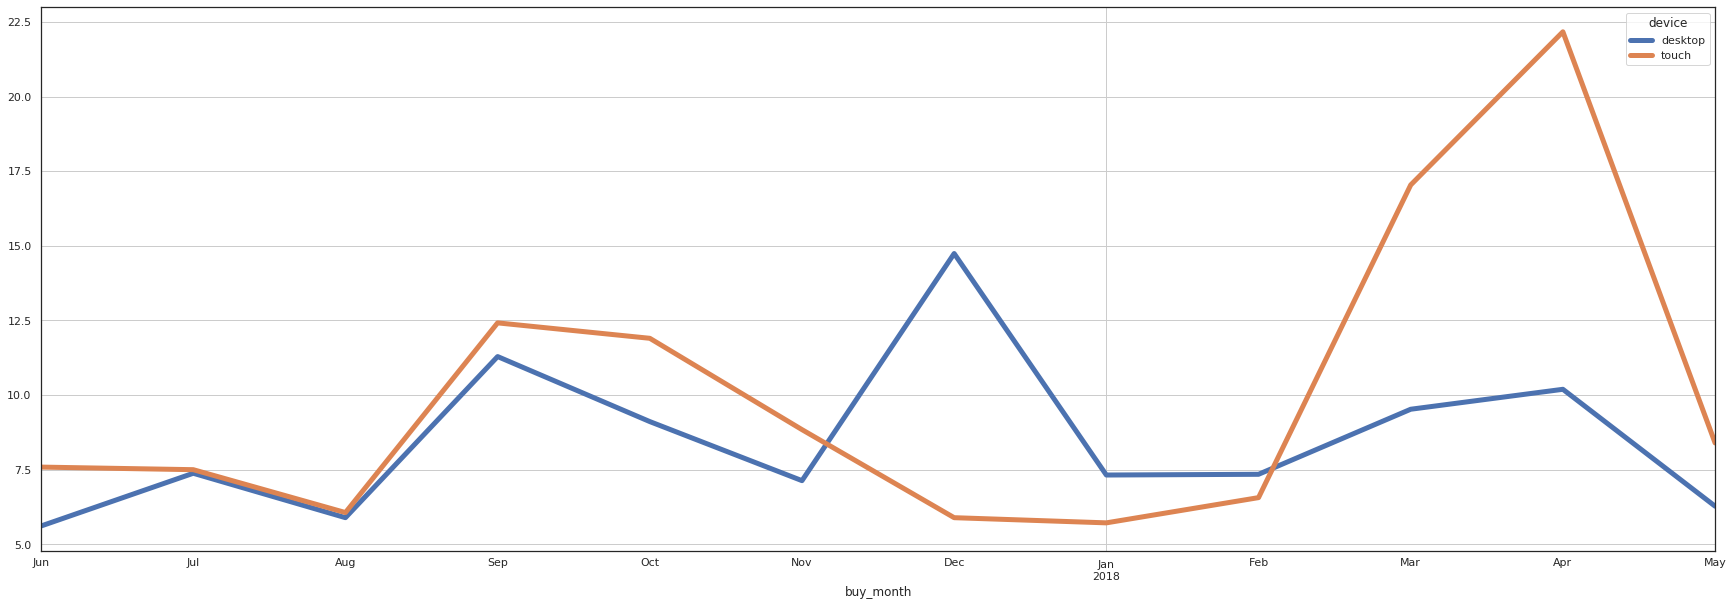

In [32]:
temp = period_orders.pivot_table(index='buy_month', columns='device', values='revenue', aggfunc='mean')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Средний чек за месяц c устройства', i, temp[i].mean())

Посмотрим, сколько денег люди приносят сервису, и как этот показатель меняется во времени. Посчитаем LTV по когортам.

Посмотрим на распределение заказов.

In [33]:
period_orders['buy_ts'].describe()

count                  761802
unique                  45990
top       2017-11-27 12:41:00
freq                      761
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

In [34]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Дата первой и последней покупки совпадает в таблице доходов и в таблице расходов.
Данные ровно за год. Удобнее всего сформировать месячные когорты. Выделим месяцы из дат в таблицах с заказами и расходами:

In [35]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

# Получим таблицу с первым месяцем покупки для каждого покупателя
first_orders = orders.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# Посчитаем количество новых покупателей за каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new = orders.merge(first_orders, on='uid')

# Сгруппируем по месяцу первой покупки и месяцу каждого заказа, просуммируем выручку
cohorts = orders_new.groupby(['first_order_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
print(cohorts.head())

  first_order_month  buy_month  revenue
0        2017-06-01 2017-06-01  9557.49
1        2017-06-01 2017-07-01   981.82
2        2017-06-01 2017-08-01   885.34
3        2017-06-01 2017-09-01  1931.30
4        2017-06-01 2017-10-01  2068.58


In [36]:
# Добавим данные о том, сколько людей первый раз совершили покупку в каждый месяц.
report = cohort_sizes.merge(cohorts, on='first_order_month')
report['age'] = ((report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

# И, наконец, посчитаем ltv
report['ltv'] = report['revenue'] / report['n_buyers']
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)

# Выведем на экран значения выручки по среднему покупателю каждой когорты
for i in output.index:
    print('В среднем каждый покупатель из когорты', i, 'принёс по', output.loc[i].sum().round(2), 'рублей выручки за', output.loc[i].count(), 'месяцев.')

output.fillna('')

В среднем каждый покупатель из когорты 2017-06-01 00:00:00 принёс по 11.88 рублей выручки за 12 месяцев.
В среднем каждый покупатель из когорты 2017-07-01 00:00:00 принёс по 8.4 рублей выручки за 11 месяцев.
В среднем каждый покупатель из когорты 2017-08-01 00:00:00 принёс по 8.47 рублей выручки за 10 месяцев.
В среднем каждый покупатель из когорты 2017-09-01 00:00:00 принёс по 13.43 рублей выручки за 9 месяцев.
В среднем каждый покупатель из когорты 2017-10-01 00:00:00 принёс по 6.36 рублей выручки за 8 месяцев.
В среднем каждый покупатель из когорты 2017-11-01 00:00:00 принёс по 6.38 рублей выручки за 7 месяцев.
В среднем каждый покупатель из когорты 2017-12-01 00:00:00 принёс по 7.65 рублей выручки за 6 месяцев.
В среднем каждый покупатель из когорты 2018-01-01 00:00:00 принёс по 4.93 рублей выручки за 5 месяцев.
В среднем каждый покупатель из когорты 2018-02-01 00:00:00 принёс по 4.59 рублей выручки за 4 месяцев.
В среднем каждый покупатель из когорты 2018-03-01 00:00:00 принёс по 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


Сентябрь кажется наиболее подходящим месяцем для того, чтобы влиться в культурную жизнь города.

Взглянем, сколько денег потратили. Всего / на каждый источник / по времени

In [37]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['week'] = costs['dt'].astype('datetime64[W]')
print('Всего за год на маркетинг потратили:', costs['costs'].sum())

Всего за год на маркетинг потратили: 329131.62


Средний ежедневный расход на рекламный источник 1 составляет: 57.39
Средний ежедневный расход на рекламный источник 2 составляет: 117.92
Средний ежедневный расход на рекламный источник 3 составляет: 389.32
Средний ежедневный расход на рекламный источник 4 составляет: 168.25
Средний ежедневный расход на рекламный источник 5 составляет: 142.19
Средний ежедневный расход на рекламный источник 9 составляет: 15.2
Средний ежедневный расход на рекламный источник 10 составляет: 16.04


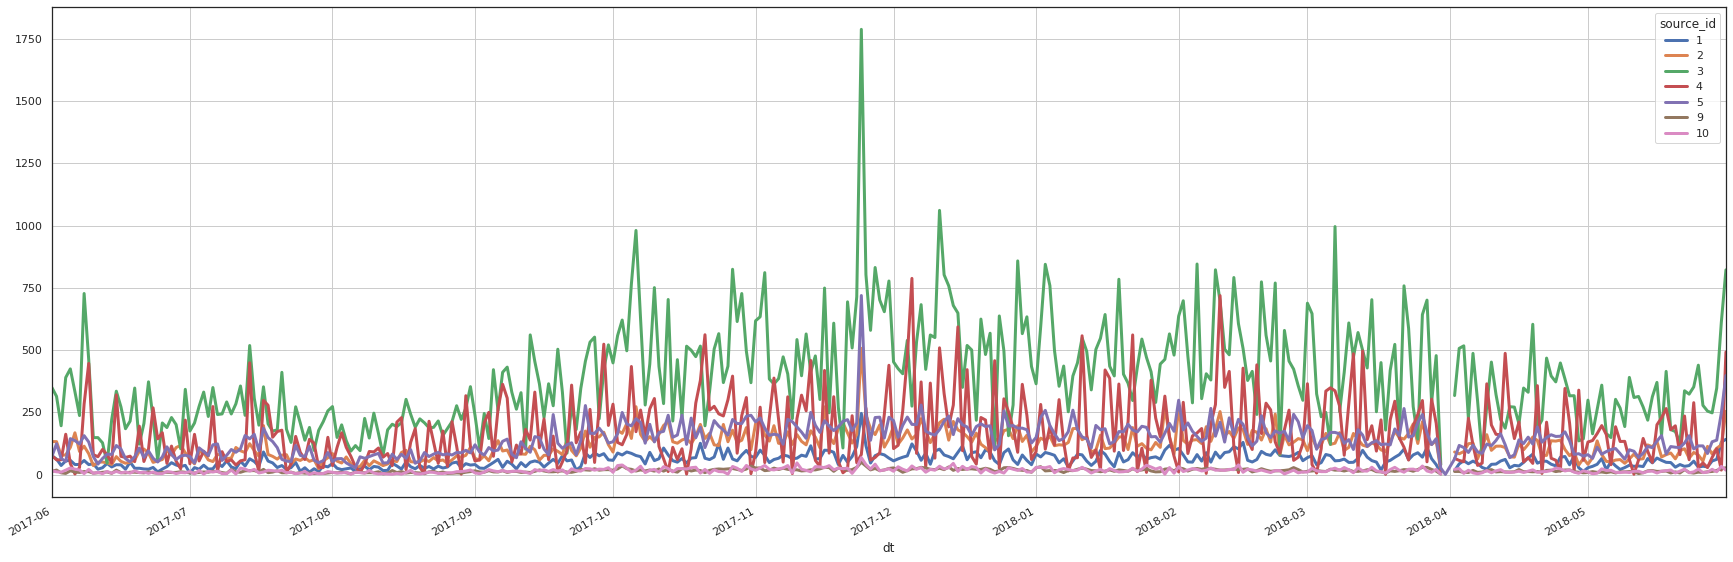

In [38]:
temp = costs.pivot_table(index='dt', columns='source_id', values='costs', aggfunc='sum')
temp.plot(figsize=(30, 10), grid=True, linewidth=3)
for i in temp.columns:
    print('Средний ежедневный расход на рекламный источник', i, 'составляет:', temp[i].mean().round(2))

Не очень информативный график. Явно выделяется только рекламный источник "3"

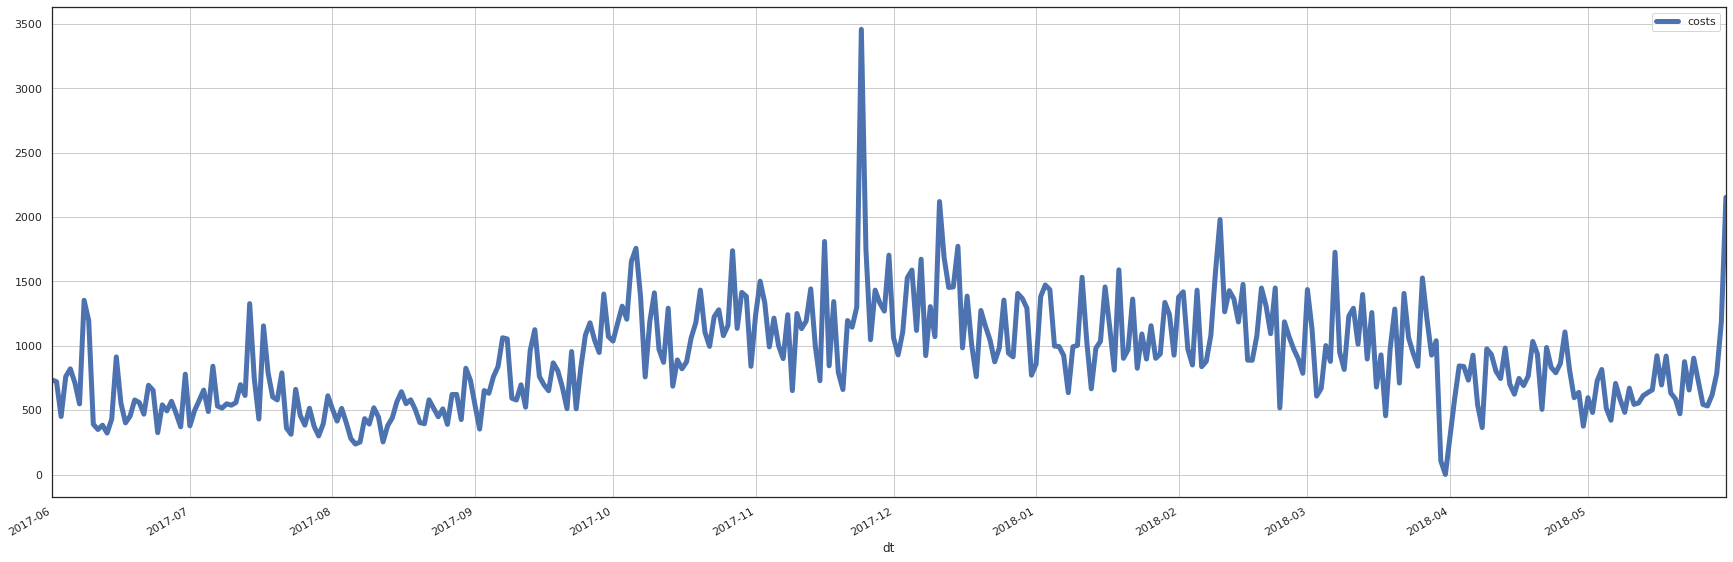

In [39]:
# Суммарный расход в день
temp = costs.pivot_table(index='dt', values='costs', aggfunc='sum')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)

Средний еженедельный расход на рекламный источник 1 составляет: 393.08
Средний еженедельный расход на рекламный источник 2 составляет: 807.66
Средний еженедельный расход на рекламный источник 3 составляет: 2666.45
Средний еженедельный расход на рекламный источник 4 составляет: 1152.33
Средний еженедельный расход на рекламный источник 5 составляет: 976.55
Средний еженедельный расход на рекламный источник 9 составляет: 104.1
Средний еженедельный расход на рекламный источник 10 составляет: 109.86


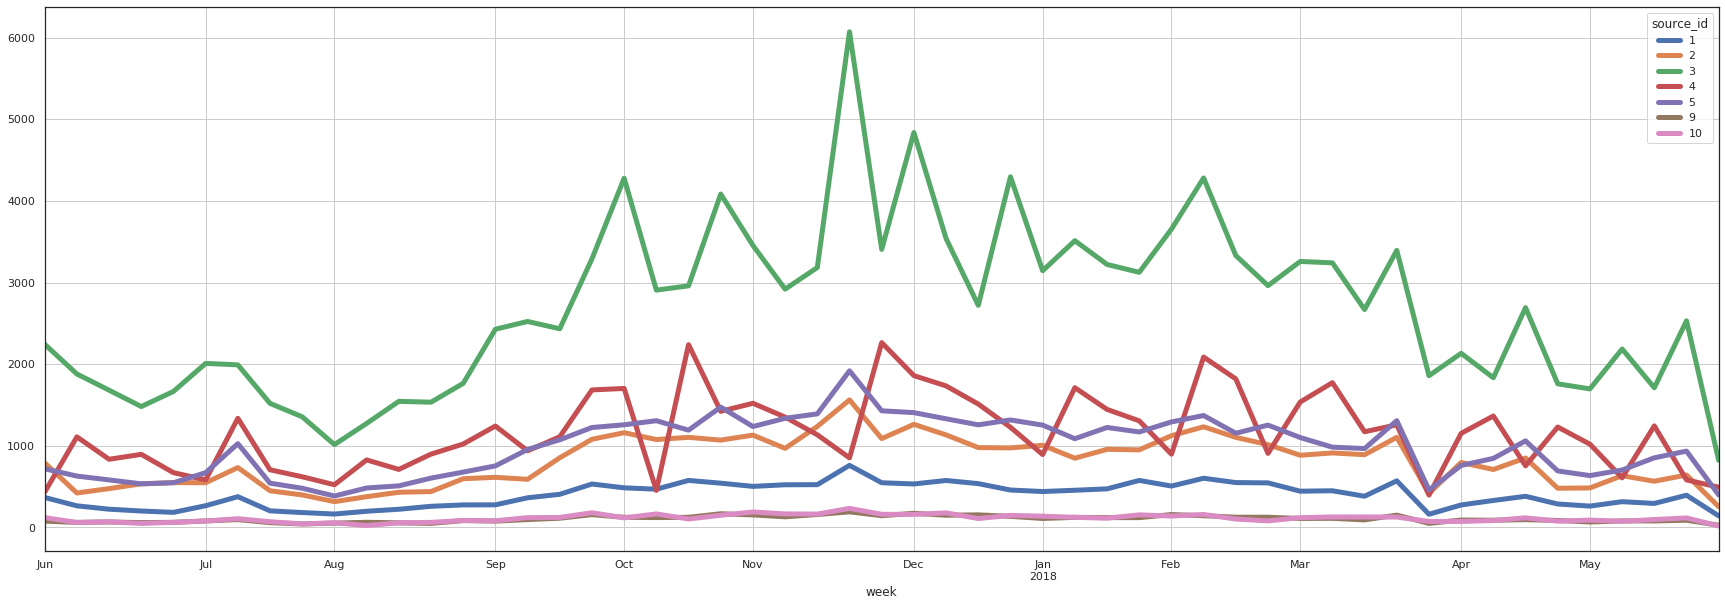

In [40]:
temp = costs.pivot_table(index='week', columns='source_id', values='costs', aggfunc='sum')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Средний еженедельный расход на рекламный источник', i, 'составляет:', temp[i].mean().round(2))

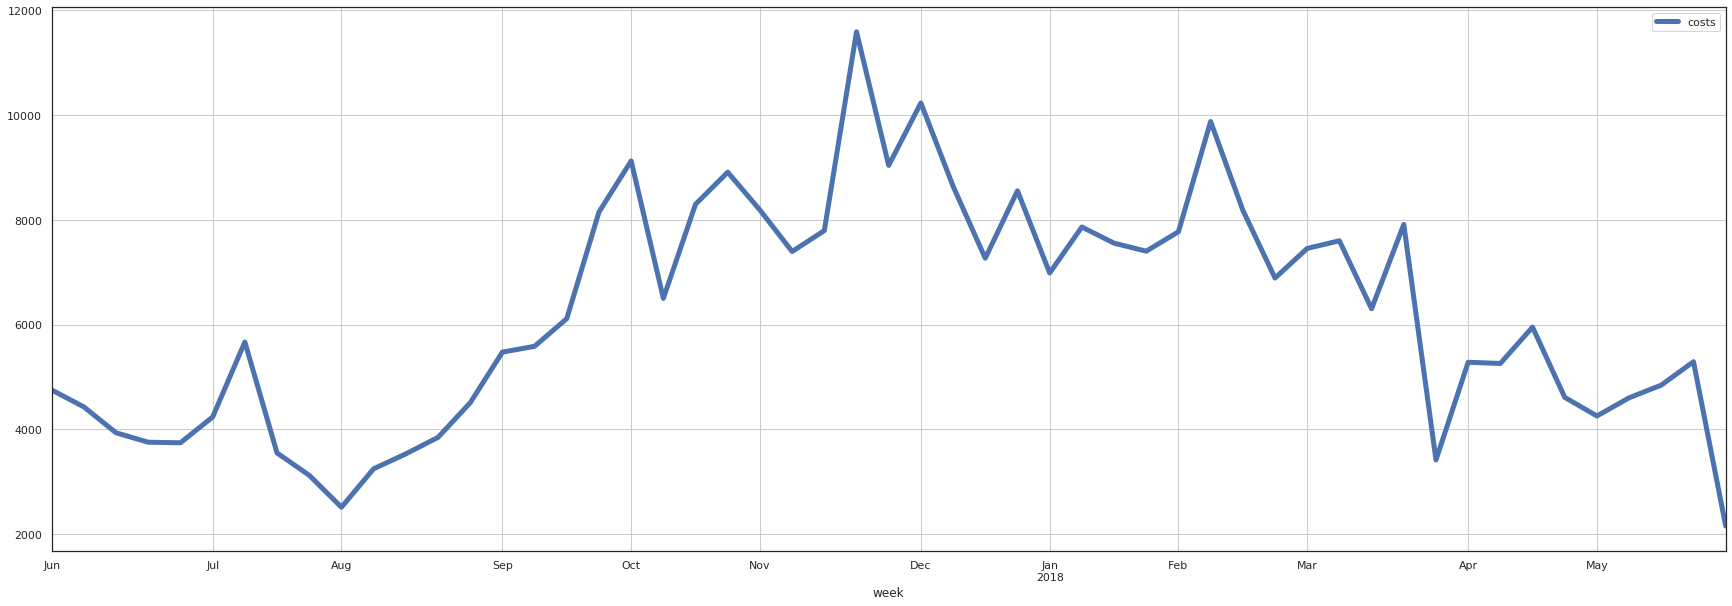

In [41]:
# Суммарный расход в неделю
temp = costs.pivot_table(index='week', values='costs', aggfunc='sum')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)

Средний ежемесячный расход на рекламный источник 1 составляет: 1736.11
Средний ежемесячный расход на рекламный источник 2 составляет: 3567.17
Средний ежемесячный расход на рекламный источник 3 составляет: 11776.8
Средний ежемесячный расход на рекламный источник 4 составляет: 5089.47
Средний ежемесячный расход на рекламный источник 5 составляет: 4313.09
Средний ежемесячный расход на рекламный источник 9 составляет: 459.79
Средний ежемесячный расход на рекламный источник 10 составляет: 485.21


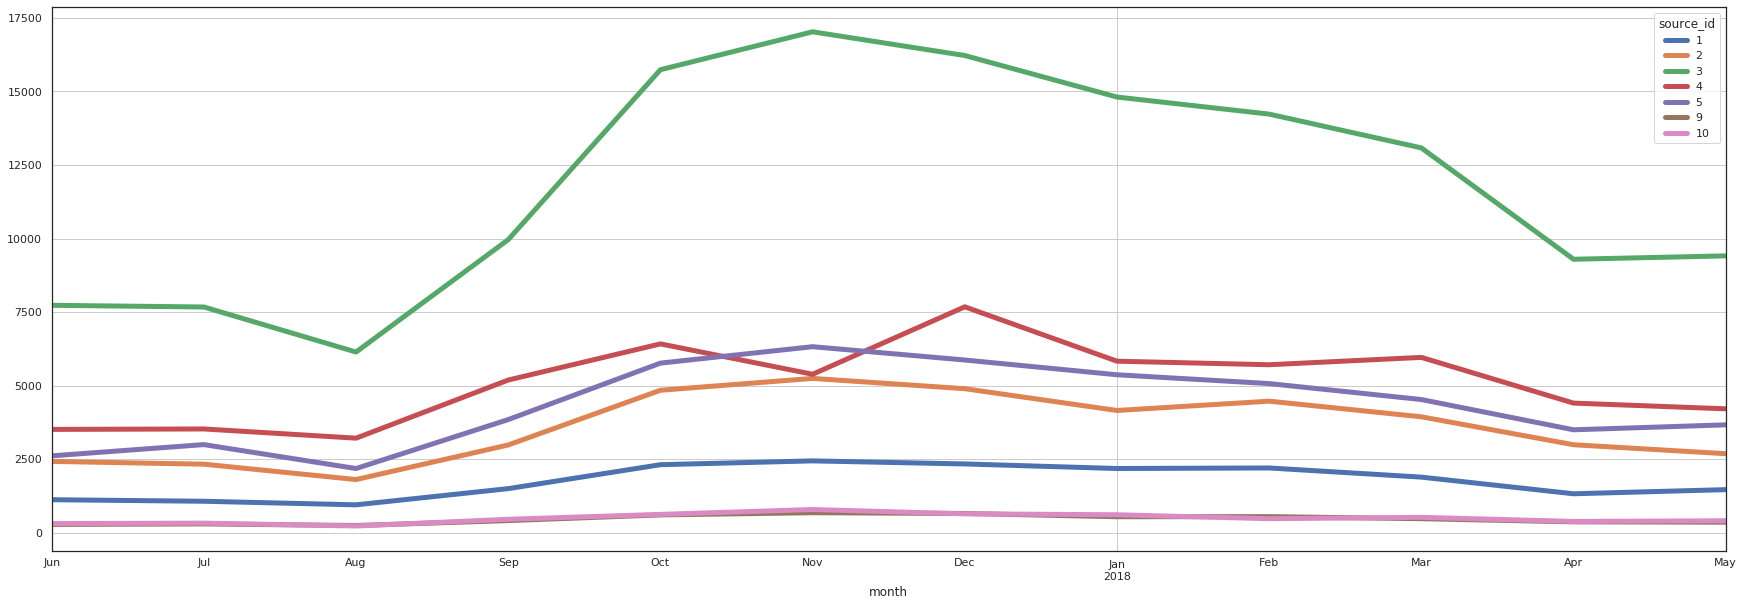

In [42]:
temp = costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)
for i in temp.columns:
    print('Средний ежемесячный расход на рекламный источник', i, 'составляет:', temp[i].mean().round(2))

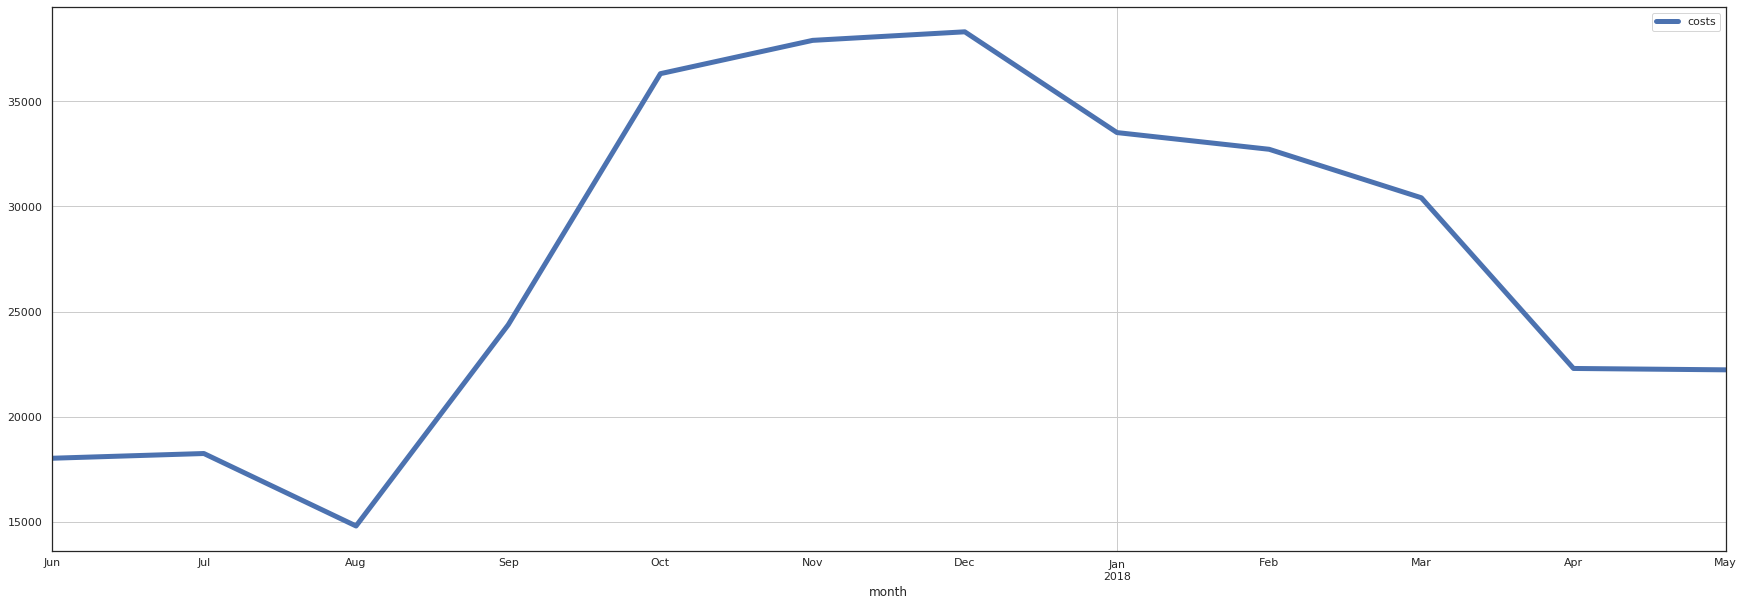

In [43]:
# Суммарный расход в месяц
temp = costs.pivot_table(index='month', values='costs', aggfunc='sum')
temp.plot(figsize=(30, 10), grid=True, linewidth=5)

Где пиковые продажи, там пиковые расходы. Неудивительно, что рост расходов характерен для любого времени года, за исключением лета.

Выясним, сколько стоило привлечение одного покупателя из каждого источника.

In [44]:
# считаем расходы за месяц
monthly_costs = costs.groupby(['month', 'source_id']).agg({'costs': 'sum'}).reset_index()

# Добавляем данные в уже имеющуюся таблицу report, где содержится выручка каждого месяца жизни когорты и LTV
report_new = report.merge(monthly_costs, left_on='first_order_month', right_on='month')

# Вычисляем САС: делим стоимость маркетинга на количество покупателей
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

# Оставим в таблице только те строки, где возраст когорты равен нулю и сгенерируем таблицу САС для каждого источника
report_new = report_new[report_new['age'] == 0]
cac_table = report_new.pivot_table(index='source_id', columns='month', values='cac', aggfunc='sum')
cac_table.round(2)

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,0.56,0.56,0.69,0.58,0.53,0.60,0.53,0.65,0.60,0.54,0.58,0.49
2,1.20,1.21,1.32,1.16,1.12,1.29,1.12,1.23,1.23,1.12,1.32,0.90
3,3.82,3.99,4.48,3.86,3.63,4.17,3.70,4.39,3.90,3.70,4.08,3.15
4,1.74,1.84,2.35,2.01,1.48,1.32,1.75,1.73,1.56,1.69,1.94,1.41
5,1.29,1.56,1.60,1.49,1.33,1.55,1.34,1.59,1.39,1.28,1.54,1.23
9,0.14,0.16,0.18,0.16,0.14,0.17,0.15,0.16,0.15,0.14,0.16,0.12
10,0.16,0.17,0.17,0.18,0.14,0.19,0.15,0.18,0.13,0.15,0.17,0.14


Данная таблица показывает, сколько было затрачено средств для привлечения одного покупателя каждой когорты посредством всех рекламных источников.

Теперь посмотрим, на сколько окупились расходы? Посчитаем ROI.

Посчитаем отдельно LTV и CAC по когортам и по источникам
По когортам:

In [45]:
monthly_costs = costs.groupby(['month']).agg({'costs': 'sum'}).reset_index()
report_new = report.merge(monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


In [46]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем когорты окупаются после 8 месяцев, но не будем забывать, что затраты проекта исчисляются не только расходами на рекламу.

In [47]:
# Выделим таблицу сопоставлений uid и source_id
g_visits = visits.pivot_table(index='uid', values='source_id', aggfunc='first').reset_index()

# Добавим ее в ранее созданную period_orders
new_period_orders = orders.merge(g_visits, on='uid')

# Добавим в таблицу заказов месяц первого заказа (месяц привлечения клиента) и источник рекламы для каждого конкретного пользователя
grouped_period_orders = orders.merge(first_orders, on='uid').merge(new_period_orders[['uid', 'source_id']].drop_duplicates(), on='uid')

# Сведём в таблицу, где для каждого источника и месяца привлечения покупателя будет
# среднее количество выручки за всё время на одного пользователя
grouped_period_orders = grouped_period_orders.pivot_table(index='source_id', columns='first_order_month', values='revenue', aggfunc='mean')
grouped_period_orders.round(2)

first_order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,6.70,7.48,5.06,8.92,5.85,4.88,3.60,5.36,4.29,6.13,6.31,4.51
2,7.50,5.58,5.29,23.18,6.36,4.45,14.39,3.93,3.67,4.81,4.63,5.72
3,4.12,4.84,4.96,4.47,3.96,4.50,3.82,3.77,3.66,3.97,3.74,3.64
4,4.68,5.65,4.95,4.82,3.96,4.66,3.74,3.45,3.75,4.29,4.75,4.40
5,4.45,4.86,5.71,4.36,4.69,3.96,4.55,3.94,3.88,3.92,3.82,3.87
7,NaN,NaN,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.81,4.38,6.41,3.47,3.47,3.44,3.07,2.53,3.15,2.29,4.14,3.58
10,1.96,3.03,4.11,2.17,2.50,3.39,3.46,2.86,2.43,2.85,2.48,3.60


In [48]:
# Посчитаем ROI
grouped_period_orders / cac_table

first_order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,12.042674,13.410799,7.281811,15.328732,10.967336,8.137265,6.742291,8.269604,7.109675,11.437196,10.815309,9.178277
2,6.251184,4.598527,4.001465,20.035739,5.694975,3.457368,12.878662,3.184610,2.994339,4.305855,3.517597,6.358603
3,1.078228,1.211715,1.106145,1.158411,1.091406,1.079319,1.031571,0.859302,0.938317,1.071955,0.915137,1.154415
4,2.694939,3.075822,2.109586,2.393977,2.677501,3.531931,2.135982,1.993595,2.399611,2.542337,2.450312,3.119239
5,3.438830,3.114766,3.580052,2.926147,3.528047,2.553110,3.393892,2.475730,2.795430,3.058289,2.482382,3.148158
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,19.925028,27.820565,35.264283,21.524345,24.693297,20.522732,20.468446,15.616636,20.881133,16.815127,25.221397,29.521231
10,12.649460,17.665129,24.216786,12.131692,17.298978,17.455796,23.471817,15.684501,18.460592,19.129068,14.556981,26.252185


Как видим, использующиеся рекламные источники все хороши, за исключением одного - "3". На него высокие затраты, и на протяжении целого года он едва себя отбивал. Источник "7" требует дополнительно разъяснения, поскольку принес какой-то доход без каких-либо затрат. Стоит обратить внимание на высокие показатели ROI источников "1", "9", "10" - круглый год эти рекламные источники привлекают покупателей с наибольшей выгодой.

### Вывод

Проанализировав все графики и полученные показатели, можно сделать следующие умозаключения:
- Среднее количество пользователей продукта в день c устройства desktop превышает количество пользователей продукта с устройства touch в среднем в 2,5 раза при примерно одинаковых средних чеках с той и другой платформы. Поскольку мобильные постепенно вытесняют десктопные платформы, стоит обратить внимание на мобильное приложение, исследовать его, тщательно протестировать - вполне вероятно, что с точки зрения удобства использования там есть недочёты. Возможно в приложении присутствуют рекламные блоки, которые отталкивают пользователей от приложения, и, как следствие, от продукта в целом.
- Расчёт коэффициента возврата инвестиций (ROI) для разных источников выделил источники "1", "9", "10" как наиболее успешно внедрённые на протяжении всего исследуемого года. Если и делать ставку на какие-либо источники, то именно на эти. И, как противопоставление, наименее окупаемый источник - "3". При наибольших суммах бюджета, выделенного на этот рекламный источник, и без учета дополнительных затрат коэффициент возврата инвестиций далеко не всегда превышает значение 1.
- Расчёт коэффициента возврата инвестиций для разных когорт пользователей (разбиты на месяцы первых покупок) показал, что маркетинг окупается в среднем после 8 месяцев. Привлеченные в июне 2017 года вышли на ROI > 1 после 6 месяцев, а те, что в сентябре, после 3 месяцев. Пришедшие в июле-августе, не окупили себя даже спустя 10 месяцев. По остальным когортам сложно делать однозначные выводы, поскольку данные по ним есть лишь за малый промежуток времени, но можно предположить, что когорта мая 2018 года вполне может вывести на самоокупаемость за срок, меньше среднего.
- Летний период характеризуется наименьшей покупательской способностью. Низкие показатели продаж здесь связаны со спадом культурной деятельности и альтернативных видов отдыха в сезон отпусков. Впрочем, летом проводятся крупные музыкальные фестивали, об этом не стоит забывать при формировании контекстной рекламы и направления источника рекламы.
- Показатель Retention Rate, рассчитанный с помощью когортного анализа указывает на то, что после первого пользования продуктом (в течение года) к нему возвращаются во втором месяце меньше 10% пользователей. Хоть вложения в маркетинг и окупают столь высокий отток, стоит подумать как можно улучшить продукт - опять же возвращаемся к удобству пользования продуктом на платформах, в первую очередь touch, и к каким-либо дополнительным поощрениям пользователя (скидки, купоны, акции).
- Пиковые значения продаж характерны для периода "Чёрной пятницы", Нового Года, 23 февраля, 8 марта и конца мая (перед периодом летних фестивалей). Стоит учитывать данные события при принятии ежемесячного бюджета на маркетинг для наиболее эффективного распределения средств.

Для выполненного анализа мы использовали когортный анализ и экономику одной продажи (рассчитали «пожизненную» ценность клиента, стоимость привлечения клиента и коэффициент возврата инвестиций), рассчитали коэффициент удержания и продемонстрировали на графиках все изменения показателей в течение выделенного года.